# Recommender system Case Study

You are part of a team that has to build a recommender engine for used cars. The
recommender engine will be used by many branches in different parts of the world
independently. The recommender results will be presented to potential buyers in form of an
interactive website.

You surely know the best what are your areas of expertise and what would you want to do with
this project, but down below are some ideas for inspiration what you can focus on. ( Please
try to focus on things you are best in. Omit parts you do not have an expertise in. )

**Data engineering / Data science**
- make some exploratory data analysis with the data to extract information more valuable
than only the basics present in the original dataset
- prepare a data pipeline to automatically download, preprocess and extract features from
the dataset
- prepare a model to recommend similar cars on the web page with aim at maximizing
profit and a reasonable user experience
- suggest a ML Ops solution to handle model training every day from new data, checking
data drift, concept drift, correct data types

## Imports

In [1]:
# to install all libraries run `pip install -r requirements.txt`
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("/Users/vaclavcepelak/PycharmProjects/cars-recommender")

import os
import re
from urllib.request import urlopen

import numpy as np
import pandas as pd
import polars as pl
from bs4 import BeautifulSoup

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from unidecode import unidecode
# Note: run `pip install --upgrade Pillow` to be sure the library works correctly
from ydata_profiling import ProfileReport

from cars_recommender.src.helpers import (get_country_data, get_feature_names,
                                          plot_hist)

## Data load

In [2]:
# download dataset via Kaggle API
# https://towardsdatascience.com/how-to-search-and-download-data-using-kaggle-api-f815f7b98080
os.system(
    "kaggle datasets download -d nehalbirla/vehicle-dataset-from-cardekho -p ../data/external/ --unzip"
)

  0%|          | 0.00/292k [00:00<?, ?B/s]

100%|██████████| 292k/292k [00:00<00:00, 903kB/s]


0

In [3]:
# download the car models data via Kaggle API
os.system(
    "kaggle datasets download -d peshimaammuzammil/2023-car-model-dataset-all-data-you-need -p ./data/ --unzip"
)

100%|██████████| 12.0k/12.0k [00:00<00:00, 14.2MB/s]


0

In [4]:
# list files downloaded
os.listdir("../data/external/")

['car data.csv',
 '.gitkeep',
 'CAR DETAILS FROM CAR DEKHO.csv',
 'car details v4.csv',
 'Car details v3.csv']


For the purpose of the demo, the file `Car details v3.csv` is used:
- The files `car data.csv` and `CAR DETAILS FROM CAR DEKHO.csv` contain very small set of features
- The file `car details v4.csv` has some additional features but the sample is smaller.



## Data preparation

### Cars data

In [5]:
df_cars = pl.read_csv("../data/external/Car details v3.csv").with_columns(
    [
        # assign brand of the car
        pl.col("name").str.extract(r"^(\b\w+\b) (.*)$", 1).alias("company"),
        pl.col("name").str.extract(r"^(\b\w+\b) (.*)$", 2).alias("model"),
        # cast mileage to float
        pl.col("mileage")
        .str.extract(r"^([0-9\.]+) (.+)$", 1)
        .cast(pl.Float32)
        .alias("mileage_num"),
        pl.col("mileage").str.extract(r"^([0-9\.]+) (.+)$", 2).alias("mileage_unit"),
        # cast engine vol
        pl.col("engine")
        .str.extract(r"^([0-9]+) (.+)$", 1)
        .cast(pl.Int32)
        .alias("engine_vol_num"),
        pl.col("engine").str.extract(r"^([0-9]+) (.+)$", 2).alias("engine_vol_unit"),
        # cast max power to float
        pl.col("max_power")
        .str.extract(r"^([0-9\.]+) (.+$)", 1)
        .cast(pl.Float32)
        .alias("max_power_num"),
        pl.col("max_power")
        .str.extract(r"^([0-9\.]+) (.+$)", 2)
        .alias("max_power_unit"),
        # compute car age (max(year) - year)
        (pl.col("year").max() - pl.col("year")).alias("car_age"),
    ]
)

In [6]:
# 8128 rows
df_cars.shape

(8128, 22)

In [7]:
# get only complete cases for the purpose of demo (7906)
# TODO: prepare a solution for incomplete cases
df_cars = df_cars.filter(~pl.any_horizontal(pl.col("*").is_null()))
df_cars.shape

(7852, 22)

In [8]:
df_cars.head(5)

name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,company,model,mileage_num,mileage_unit,engine_vol_num,engine_vol_unit,max_power_num,max_power_unit,car_age
str,i64,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,f32,str,i32,str,f32,str,i64
"""Maruti Swift D…",2014,450000,145500,"""Diesel""","""Individual""","""Manual""","""First Owner""","""23.4 kmpl""","""1248 CC""","""74 bhp""","""190Nm@ 2000rpm…",5,"""Maruti""","""Swift Dzire VD…",23.4,"""kmpl""",1248,"""CC""",74.0,"""bhp""",6
"""Skoda Rapid 1.…",2014,370000,120000,"""Diesel""","""Individual""","""Manual""","""Second Owner""","""21.14 kmpl""","""1498 CC""","""103.52 bhp""","""250Nm@ 1500-25…",5,"""Skoda""","""Rapid 1.5 TDI …",21.139999,"""kmpl""",1498,"""CC""",103.519997,"""bhp""",6
"""Honda City 201…",2006,158000,140000,"""Petrol""","""Individual""","""Manual""","""Third Owner""","""17.7 kmpl""","""1497 CC""","""78 bhp""","""12.7@ 2,700(kg…",5,"""Honda""","""City 2017-2020…",17.700001,"""kmpl""",1497,"""CC""",78.0,"""bhp""",14
"""Hyundai i20 Sp…",2010,225000,127000,"""Diesel""","""Individual""","""Manual""","""First Owner""","""23.0 kmpl""","""1396 CC""","""90 bhp""","""22.4 kgm at 17…",5,"""Hyundai""","""i20 Sportz Die…",23.0,"""kmpl""",1396,"""CC""",90.0,"""bhp""",10
"""Maruti Swift V…",2007,130000,120000,"""Petrol""","""Individual""","""Manual""","""First Owner""","""16.1 kmpl""","""1298 CC""","""88.2 bhp""","""11.5@ 4,500(kg…",5,"""Maruti""","""Swift VXI BSII…",16.1,"""kmpl""",1298,"""CC""",88.199997,"""bhp""",13


### Additional sources

Scrape a Wikipedia page to get country of origin for each car manufacturer

In [9]:
# Specify url of the web page
source = urlopen("https://en.wikipedia.org/wiki/List_of_car_brands").read()
# Make a soup
soup = BeautifulSoup(source, "lxml")

In [10]:
data = []

for h in soup.select("h2:has(~ul)"):
    if "See also" not in h.text:
        country = h.text.split("[")[0]
        for tag in h.next_siblings:
            if (tag.name == "ul") or (
                tag.name == "div" and len(tag.text.split("\n")) >= 5
            ):
                for x in tag.text.split("\n"):
                    if x != "":
                        # remove brackets
                        company = re.sub(
                            r"\[[^\]]*\]|\([^\)]*\)", "", x.split("[")[0]
                        ).rstrip()
                        data.append({"company": company, "country": country})
            elif tag.name == "h2":
                break

In [11]:
unique_countries = set([d["country"] for d in data])

In [12]:
country_data = [get_country_data(country) for country in unique_countries]

In [13]:
df_country = (
    pl.DataFrame(data)
    .join(pl.DataFrame(country_data), how="left", on="country")
    .with_columns(
        pl.col("company").alias("company_orig"),
        pl.col("company")
        .str.extract(r"^(\b\w+\b)( (.*))*$", 1)
        .apply(lambda x: unidecode(x)),  # .alias('company_clean'),
    )
    .sort(
        "company_orig"
    )  # there are duplicates like Chevrolet (US) and Chevrolet Korea (South Korea)
    .unique(subset="company")
)

## Data cleaning

In [14]:
columns = [
    "company",
    "model",
    "year",
    "car_age",
    "selling_price",
    "km_driven",
    "seats",
    "seller_type",
    "fuel",
    "transmission",
    "owner",
    "mileage_num",
    "engine_vol_num",
    "max_power_num",
    "country",
    "region",
    "capital_gps_lat",
    "capital_gps_lng",
]

In [15]:
df = df_cars.join(df_country, on="company", how="left").select(columns)

In [16]:
df.head(5)

company,model,year,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,mileage_num,engine_vol_num,max_power_num,country,region,capital_gps_lat,capital_gps_lng
str,str,i64,i64,i64,i64,i64,str,str,str,str,f32,i32,f32,str,str,f64,f64
"""Maruti""","""Swift Dzire VD…",2014,6,450000,145500,5,"""Individual""","""Diesel""","""Manual""","""First Owner""",23.4,1248,74.0,"""India""","""Asia""",28.614179,77.202266
"""Skoda""","""Rapid 1.5 TDI …",2014,6,370000,120000,5,"""Individual""","""Diesel""","""Manual""","""Second Owner""",21.139999,1498,103.519997,"""Czech Republic…","""Europe""",50.087465,14.421254
"""Honda""","""City 2017-2020…",2006,14,158000,140000,5,"""Individual""","""Petrol""","""Manual""","""Third Owner""",17.700001,1497,78.0,"""Japan""","""Asia""",35.682839,139.759455
"""Hyundai""","""i20 Sportz Die…",2010,10,225000,127000,5,"""Individual""","""Diesel""","""Manual""","""First Owner""",23.0,1396,90.0,"""South Korea""","""Asia""",37.566679,126.978291
"""Maruti""","""Swift VXI BSII…",2007,13,130000,120000,5,"""Individual""","""Petrol""","""Manual""","""First Owner""",16.1,1298,88.199997,"""India""","""Asia""",28.614179,77.202266


In [17]:
# produce an interactive profile report
ProfileReport(df.to_pandas()).to_file("../reports/eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The EDA key results:
- `car_age` is approximately log-normal, which is expected but can harm our linear model
- `selling_price` is approximately log-normal (as expected) but there are some massive outliers, which need to be investigated
- `max_power_num` and `km_driven` have some outliers as well (and we should use logarithmic transformation), the other continuous features seem to be reasonably distributed
- 5 missing values in `country`, `region` and `gps*` columns - let's remove those for now and focus on them later on

In [18]:
# remove empty values in country
df = df.filter(~pl.col("country").is_null())

In [19]:
df["selling_price"].describe()

statistic,value
str,f64
"""count""",7847.0
"""null_count""",0.0
"""mean""",637597.461068
"""std""",792707.161053
"""min""",29999.0
"""25%""",265000.0
"""50%""",450000.0
"""75%""",680000.0
"""max""",1e7


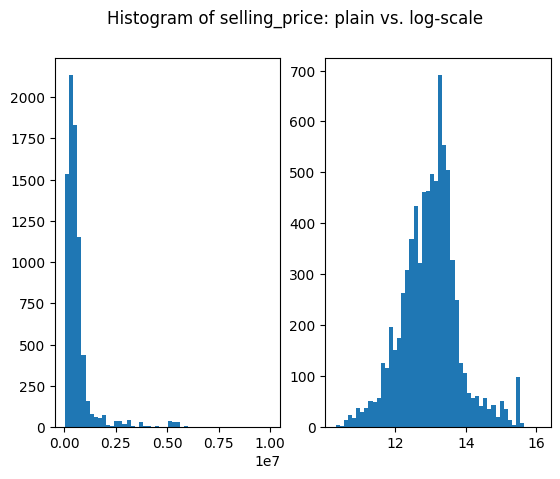

In [20]:
fig = plot_hist(df, "selling_price")

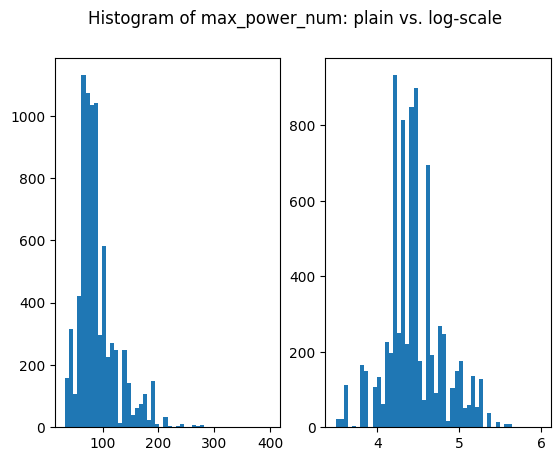

In [21]:
fig = plot_hist(df, "max_power_num")

In [22]:
df.sort("selling_price", descending=True).head(5)

company,model,year,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,mileage_num,engine_vol_num,max_power_num,country,region,capital_gps_lat,capital_gps_lng
str,str,i64,i64,i64,i64,i64,str,str,str,str,f32,i32,f32,str,str,f64,f64
"""Volvo""","""XC90 T8 Excell…",2017,3,10000000,30000,4,"""Individual""","""Petrol""","""Automatic""","""First Owner""",42.0,1969,400.0,"""Sweden""","""Europe""",59.325117,18.071094
"""BMW""","""X7 xDrive 30d …",2020,0,7200000,5000,7,"""Individual""","""Diesel""","""Automatic""","""First Owner""",13.38,2993,265.0,"""Germany""","""Europe""",52.517036,13.38886
"""Audi""","""A6 35 TFSI Mat…",2019,1,6523000,23600,5,"""Dealer""","""Petrol""","""Automatic""","""Test Drive Car…",15.26,1798,187.740005,"""Germany""","""Europe""",52.517036,13.38886
"""Audi""","""A6 35 TFSI Mat…",2019,1,6223000,7800,5,"""Dealer""","""Petrol""","""Automatic""","""Test Drive Car…",15.26,1798,187.740005,"""Germany""","""Europe""",52.517036,13.38886
"""BMW""","""6 Series GT 63…",2018,2,6000000,28156,4,"""Dealer""","""Diesel""","""Automatic""","""First Owner""",17.09,2993,261.399994,"""Germany""","""Europe""",52.517036,13.38886


In [23]:
df.sort("selling_price", descending=False).head(5)

company,model,year,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,mileage_num,engine_vol_num,max_power_num,country,region,capital_gps_lat,capital_gps_lng
str,str,i64,i64,i64,i64,i64,str,str,str,str,f32,i32,f32,str,str,f64,f64
"""Maruti""","""800 AC""",1997,23,29999,80000,4,"""Individual""","""Petrol""","""Manual""","""Third Owner""",16.1,796,37.0,"""India""","""Asia""",28.614179,77.202266
"""Maruti""","""Zen LXI""",2001,19,30000,10000,5,"""Individual""","""Petrol""","""Manual""","""First Owner""",17.299999,993,60.0,"""India""","""Asia""",28.614179,77.202266
"""Maruti""","""800 Std""",2000,20,31000,56194,4,"""Individual""","""Petrol""","""Manual""","""Fourth & Above…",16.1,796,37.0,"""India""","""Asia""",28.614179,77.202266
"""Maruti""","""800 Std""",2004,16,31504,110000,4,"""Individual""","""Petrol""","""Manual""","""Third Owner""",16.1,796,37.0,"""India""","""Asia""",28.614179,77.202266
"""Maruti""","""Wagon R VXI""",2004,16,33351,90000,5,"""Individual""","""Petrol""","""Manual""","""Third Owner""",18.9,998,67.099998,"""India""","""Asia""",28.614179,77.202266


In [24]:
# recode regions to less categories
# let's make categories: India, Pakistan, Europe/US (except Belarus), East Asia (Japan/Korea), Other
df.groupby(["region", "country"]).count().sort(
    ["region", "count"], descending=[False, True]
)

region,country,count
str,str,u32
"""Americas""","""United States""",649
"""Americas""","""Brazil""",185
"""Asia""","""India""",3850
"""Asia""","""South Korea""",1367
"""Asia""","""Japan""",1117
"""Europe""","""France""",228
"""Europe""","""Germany""",159
"""Europe""","""Czech Republic…",104
"""Europe""","""United Kingdom…",80


In [25]:
df = df.with_columns(
    [
        (
            pl.when(pl.col("country").is_in(["India", "Pakistan"]))
            .then(pl.col("country"))
            .when(pl.col("country") == "Belarus")
            .then(pl.lit("other"))
            .when(pl.col("region") == "Europe")
            .then(pl.lit("Europe/US"))
            .when(pl.col("country") == "United States")
            .then(pl.lit("Europe/US"))
            .when(pl.col("country").is_in(["South Korea", "Japan"]))
            .then(pl.lit("Japan/Korea"))
            .otherwise(pl.lit("other"))
            .alias("brand_segment")
        ),
        pl.col("selling_price").apply(np.log).alias("selling_price_log"),
        pl.col("max_power_num").apply(np.log).alias("max_power_log"),
        pl.col("km_driven").apply(np.log).alias("km_driven_log"),
    ]
)

In [26]:
df.groupby("brand_segment").count()

brand_segment,count
str,u32
"""Europe/US""",1328
"""Japan/Korea""",2484
"""other""",185
"""India""",3850


In [27]:
df.groupby("brand_segment").agg(pl.col("selling_price").median()).sort(
    by="brand_segment"
)

brand_segment,selling_price
str,f64
"""Europe/US""",517500.0
"""India""",400000.0
"""Japan/Korea""",509999.0
"""other""",425000.0


## Linear regression
The goal of this model is to evaluate the monetary value of each product feature, e.g. what is the additional cost to buy a diesel engine instead of a petrol engine. These estimated values will be used to determine automatically which features are benefitial to customers.

In [28]:
df.head(5)

company,model,year,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,mileage_num,engine_vol_num,max_power_num,country,region,capital_gps_lat,capital_gps_lng,brand_segment,selling_price_log,max_power_log,km_driven_log
str,str,i64,i64,i64,i64,i64,str,str,str,str,f32,i32,f32,str,str,f64,f64,str,f64,f64,f64
"""Maruti""","""Swift Dzire VD…",2014,6,450000,145500,5,"""Individual""","""Diesel""","""Manual""","""First Owner""",23.4,1248,74.0,"""India""","""Asia""",28.614179,77.202266,"""India""",13.017003,4.304065,11.887931
"""Skoda""","""Rapid 1.5 TDI …",2014,6,370000,120000,5,"""Individual""","""Diesel""","""Manual""","""Second Owner""",21.139999,1498,103.519997,"""Czech Republic…","""Europe""",50.087465,14.421254,"""Europe/US""",12.821258,4.639765,11.695247
"""Honda""","""City 2017-2020…",2006,14,158000,140000,5,"""Individual""","""Petrol""","""Manual""","""Third Owner""",17.700001,1497,78.0,"""Japan""","""Asia""",35.682839,139.759455,"""Japan/Korea""",11.97035,4.356709,11.849398
"""Hyundai""","""i20 Sportz Die…",2010,10,225000,127000,5,"""Individual""","""Diesel""","""Manual""","""First Owner""",23.0,1396,90.0,"""South Korea""","""Asia""",37.566679,126.978291,"""Japan/Korea""",12.323856,4.49981,11.751942
"""Maruti""","""Swift VXI BSII…",2007,13,130000,120000,5,"""Individual""","""Petrol""","""Manual""","""First Owner""",16.1,1298,88.199997,"""India""","""Asia""",28.614179,77.202266,"""India""",11.77529,4.479607,11.695247


In [29]:
numeric_features = [
    "car_age",
    "km_driven_log",
    "mileage_num",
    "engine_vol_num",
    "max_power_log",
    "seats",
]
categorical_features = ["seller_type", "fuel", "transmission", "owner", "brand_segment"]
y_col = "selling_price_log"
all_features = numeric_features + categorical_features

In [30]:
X = df.select(all_features).to_pandas()
y = df[y_col].to_pandas()

In [31]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
numeric_features_bool = [f in numeric_features for f in all_features]
categorical_features_bool = [f in categorical_features for f in all_features]

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

In [34]:
# Define the Lasso model and parameter grid
lasso = Lasso()
param_grid = {"lasso__alpha": [10 ** (-i) for i in range(8)]}

In [35]:
# Create the pipeline with preprocessing and Lasso regression
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("lasso", lasso)])

In [36]:
# Perform grid search within the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['car_age',
                                                                          'km_driven_log',
                                                                          'mileage_num',
                                                                          'engine_vol_num',
                                                                          'max_power_log',
                                                                          'seats']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['seller_type',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'owner',
                                                                          'brand_segment'])])),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05,
                                          1e-06, 1e-07]})

In [37]:
# scoring function for Lasso is R2
# see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso.score
pl.DataFrame(grid_search.cv_results_)

mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
f64,f64,f64,f64,object,struct[1],f64,f64,f64,f64,f64,f64,f64,i32
0.013904,0.00201,0.005374,0.00056,1,{1},-0.000066,-0.000887,-0.003245,-0.001419,-0.0033,-0.001783,0.00129,8
0.012432,0.000316,0.004554,0.000171,0.1,{0},0.812335,0.796774,0.811949,0.810464,0.810844,0.808473,0.00589,7
0.020381,0.009251,0.004694,0.000544,0.01,{0},0.858934,0.857663,0.854038,0.863092,0.863741,0.859493,0.003589,6
0.042599,0.024664,0.034433,0.042125,0.001,{0},0.8643,0.864505,0.860473,0.869091,0.869459,0.865566,0.003354,5
0.027528,0.007345,0.006791,0.00208,0.0001,{0},0.86556,0.864096,0.86229,0.869207,0.870544,0.86634,0.003097,4
0.021663,0.001284,0.005189,0.000542,1e-05,{0},0.865738,0.863816,0.862455,0.869048,0.870763,0.866364,0.003122,1
0.033882,0.004713,0.005793,0.001646,1e-06,{0},0.865753,0.863787,0.862474,0.869032,0.870773,0.866364,0.003121,2
0.051554,0.00586,0.006213,0.000859,1e-07,{0},0.865755,0.863784,0.862476,0.86903,0.870774,0.866364,0.003121,3


In [38]:
grid_search.best_params_

{'lasso__alpha': 1e-05}

In [39]:
best_model = grid_search.best_estimator_

In [40]:
# Evaluate on validation data
val_score = best_model.score(X_val, y_val)
print(f"Validation score: {val_score}")

Validation score: 0.8620288602165269


In [41]:
feature_names = get_feature_names(best_model.named_steps["preprocessor"])
feature_coefs = best_model.named_steps["lasso"].coef_

In [42]:
df_coefficients = (
    pl.DataFrame({"f": feature_names, "coef": feature_coefs})
    .with_columns(
        [
            pl.col("f").str.extract(r"^([a-z]+)__.*$", 1).alias("feature_type"),
            pl.when(pl.col("f").str.starts_with("cat"))
            .then(pl.col("f").str.extract(r"^([a-z]+)__([a-z_]+)_.*$", 2))
            .otherwise(pl.col("f").str.extract(r"^([a-z]+)__([a-z_]+)$", 2))
            .alias("feature"),
            pl.when(pl.col("f").str.starts_with("cat"))
            .then(pl.col("f").str.extract(r"^([a-z]+)__([a-z_]+)_(.*)$", 3))
            .alias("category"),
        ]
    )
    .select(["feature", "category", "feature_type", "coef"])
)

In [43]:
# find reference categories
dropped_data = []
for cf in categorical_features:
    unique_categories = list(df[cf].unique())
    categories_with_coef = list(
        df_coefficients.filter(pl.col("feature") == cf)["category"]
    )
    dropped_category = [c for c in unique_categories if c not in categories_with_coef]
    dropped_data.append(
        {
            "feature": cf,
            "category": dropped_category[0],
            "feature_type": "cat",
            "coef": 0.0,
        }
    )

In [44]:
df_dropped = pl.DataFrame(dropped_data)

In [45]:
df_coefficients = pl.concat([df_coefficients, df_dropped]).sort(
    by=["feature", "category"]
)

In [46]:
df_coefficients

feature,category,feature_type,coef
str,str,str,f64
"""brand_segment""","""Europe/US""","""cat""",0.0
"""brand_segment""","""India""","""cat""",-0.008655
"""brand_segment""","""Japan/Korea""","""cat""",0.062624
"""brand_segment""","""other""","""cat""",-0.070182
"""car_age""",null,"""num""",-0.384198
"""engine_vol_num…",null,"""num""",0.155269
"""fuel""","""CNG""","""cat""",0.0
"""fuel""","""Diesel""","""cat""",0.118906
"""fuel""","""LPG""","""cat""",0.166145


In [47]:
df = (
    df.with_columns(
        pl.Series(name="predicted_selling_price_log", values=best_model.predict(X))
    )
    .with_columns(
        pl.col("predicted_selling_price_log")
        .apply(np.exp)
        .alias("predicted_selling_price")
    )
    .with_columns(
        (pl.col("predicted_selling_price_log") - pl.col("selling_price_log")).alias(
            "selling_price_log_diff"
        )
    )
)

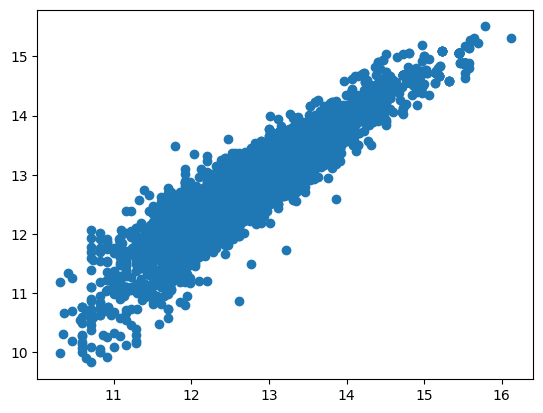

In [48]:
plt.scatter(x=df["selling_price_log"], y=df["predicted_selling_price_log"])

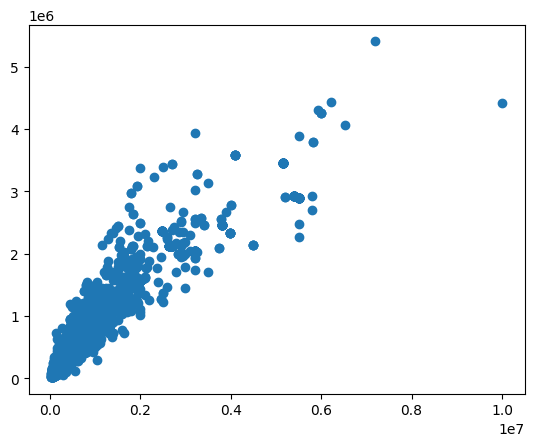

In [49]:
plt.scatter(x=df["selling_price"], y=df["predicted_selling_price"])

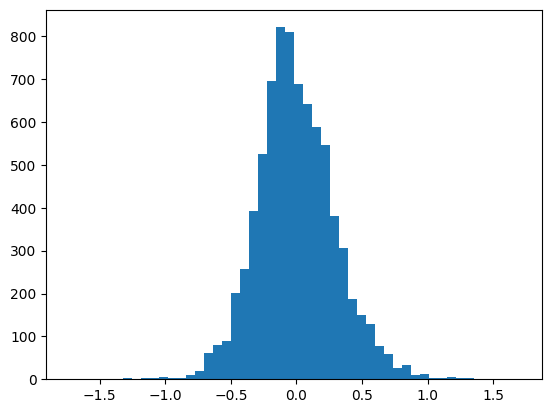

In [50]:
# `selling_price_log_diff` is a measure of the price convenience
# high values indicate that the predicted price (based on the car features) is higher than the actual price
fig = plt.hist(df["selling_price_log_diff"], bins=50)

## Recommendation engine

The content-based recommendation engine will be used. We are looking for products (cars) with as similar features as possible.

In [51]:
# create a pipeline
reco_numeric_features = [
    "car_age",
    "km_driven_log",
    "mileage_num",
    "engine_vol_num",
    "max_power_log",
    "seats",
]
reco_categorical_features = [
    "company",
    "country",
    "region",
    "seller_type",
    "fuel",
    "transmission",
    "owner",
    "brand_segment",
]
reco_all_features = reco_numeric_features + reco_categorical_features

In [52]:
X = df.select(reco_all_features).to_pandas()

In [53]:
reco_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), reco_numeric_features),
        ("cat", OneHotEncoder(), reco_categorical_features),  # do not drop any category
    ]
)

In [54]:
nearest_neighbors = NearestNeighbors(n_neighbors=1000)

In [55]:
# Create the pipeline with preprocessing and Lasso regression
reco_pipeline = Pipeline(
    steps=[
        ("preprocessor", reco_preprocessor),
        ("nearest_neighbors", nearest_neighbors),
    ]
)

In [56]:
reco_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['car_age', 'km_driven_log',
                                                   'mileage_num',
                                                   'engine_vol_num',
                                                   'max_power_log', 'seats']),
                                                 ('cat', OneHotEncoder(),
                                                  ['company', 'country',
                                                   'region', 'seller_type',
                                                   'fuel', 'transmission',
                                                   'owner',
                                                   'brand_segment'])])),
                ('nearest_neighbors', NearestNeighbors(n_neighbors=1000))])

In [57]:
# Use the pipeline to find the nearest neighbors for the query point
distances, indices = reco_pipeline.named_steps["nearest_neighbors"].kneighbors(
    reco_pipeline.named_steps["preprocessor"].transform(X)
)

## Recommender demo

Select any row number from `df` and the recommendations for this row will be generated.

You may apply the following business rules:
- Set `same_company = True` to prefer the cars from the same company
- Set `better_price = True` to prefer the cars that have better price than the current car (measured by `selling_price_log_diff`)
- Set `max_price_ratio = 0.1` to prefer cars with price within range +-10% of the current car selling price 
- Set `n_recommendations` to display the selected number of recommendations  

The pandas dataframe formatter demonstrates the highlighting feature of the tool: red-highlighted features are those that are poorer than the current car and green-highlighted ones are those that are better. The recommender aims to find a car with a better price / quality ratio and highlight the features that are different from the currently viewed car. 

In [58]:
row_nr = 500
same_company = True  # prefer cars from the same company
better_price = True  # prefer cars with the better price
max_price_ratio = 0.3  # prefer cars with price within range +-30% from the current one,
# will be ignored when None
n_recommendations = 3  # display 3 recommendations

In [59]:
sort_by = []
sort_by_descending = []
if same_company:
    sort_by.append("same_company")
    sort_by_descending.append(True)
if better_price:
    sort_by.append("better_price")
    sort_by_descending.append(True)
if max_price_ratio is not None:
    sort_by.append("price_in_range")
    sort_by_descending.append(True)
sort_by.append("distance")
sort_by_descending.append(False)

In [60]:
recommendations = [
    {"item": i, "distance": d}
    for i, d in zip(indices[row_nr], distances[row_nr])
    if d > 0  # exclude cars with the same attributes (might be a different recommender)
]
recommended_items = [r["item"] for r in recommendations]
recommended_items_distances = [r["distance"] for r in recommendations]

In [61]:
display_cols = [
    "company",
    "model",
    "car_age",
    "selling_price",
    "km_driven",
    "seats",
    "seller_type",
    "fuel",
    "transmission",
    "owner",
    "max_power_num",
    "mileage_num",
    "engine_vol_num",
    "predicted_selling_price",
    "selling_price_log_diff",
]

In [62]:
current_car = df.select(display_cols).row(row_nr, named=True)
print(current_car)

{'company': 'Chevrolet', 'model': 'Sail 1.2 LS ABS', 'car_age': 4, 'selling_price': 400000, 'km_driven': 30000, 'seats': 5, 'seller_type': 'Individual', 'fuel': 'Petrol', 'transmission': 'Manual', 'owner': 'First Owner', 'max_power_num': 82.4000015258789, 'mileage_num': 18.200000762939453, 'engine_vol_num': 1199, 'predicted_selling_price': 427906.4207822639, 'selling_price_log_diff': 0.0674399815358484}


In [63]:
df_recommendations = (
    df.filter(df.with_row_count()["row_nr"].is_in(recommended_items))
    .select(display_cols)
    .with_columns(
        pl.Series(name="distance", values=recommended_items_distances),
        (pl.col("company") == current_car["company"]).alias("same_company"),
        (
            pl.col("selling_price_log_diff") > current_car["selling_price_log_diff"]
        ).alias("better_price"),
        (
            (
                pl.col("selling_price")
                >= current_car["selling_price"] * (1 - max_price_ratio)
            )
            & (
                pl.col("selling_price")
                <= current_car["selling_price"] * (1 + max_price_ratio)
            )
        ).alias("price_in_range"),
    )
    .sort(by=sort_by, descending=sort_by_descending)
    .head(n_recommendations)
    .to_pandas()
)
df_recommendations

,company,model,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,max_power_num,mileage_num,engine_vol_num,predicted_selling_price,selling_price_log_diff,distance,same_company,better_price,price_in_range
0,Chevrolet,Enjoy TCDi LTZ 7 Seater,7,300000,70000,7,Individual,Diesel,Manual,First Owner,73.800003,18.200001,1248,334548.219941,0.108999,0.600067,True,True,True
1,Chevrolet,Enjoy 1.3 TCDi LS 7,4,420000,70000,7,Individual,Diesel,Manual,First Owner,73.739998,18.200001,1248,450739.877810,0.070636,2.200823,True,True,True
2,Chevrolet,Sail Hatchback LS ABS,7,300000,65000,5,Individual,Diesel,Manual,First Owner,76.900002,22.100000,1248,354237.058219,0.166184,2.397112,True,True,True


In [64]:
def highlight_rows(row):
    colors = []
    for col in row.keys():
        color = "background-color: white"
        if col in categorical_features:
            reco_coef = df_coefficients.filter(
                (pl.col("feature") == col) & (pl.col("category") == row[col])
            ).row(0, named=True)["coef"]
            current_coef = df_coefficients.filter(
                (pl.col("feature") == col) & (pl.col("category") == current_car[col])
            ).row(0, named=True)["coef"]
            if (reco_coef - current_coef) >= 0.05:
                color = "background-color: green"
            elif (reco_coef - current_coef) <= -0.05:
                color = "background-color: red"
        elif col in numeric_features:
            reco_value = row[col]
            current_value = current_car[col]
            coef = df_coefficients.filter(pl.col("feature") == col).row(0, named=True)[
                "coef"
            ]
            if abs(coef) >= 0.05:
                if np.sign(coef) * (reco_value - current_value) > 0:
                    color = "background-color: green"
                elif np.sign(coef) * (reco_value - current_value) < 0:
                    color = "background-color: red"
        elif col == "selling_price":
            reco_price = row[col]
            current_price = current_car[col]
            if reco_price > current_price:
                color = "background-color: red"
            elif reco_price < current_price:
                color = "background-color: green"
        colors.append(color)
    return colors

In [65]:
s = (
    pd.concat([pd.DataFrame([current_car]), df_recommendations])
    .reset_index()
    .style.apply(highlight_rows, axis=1)
)

In [66]:
# run in jupyter, PyCharm doesn't display HTML outputs
s

,index,company,model,car_age,selling_price,km_driven,seats,seller_type,fuel,transmission,owner,max_power_num,mileage_num,engine_vol_num,predicted_selling_price,selling_price_log_diff,distance,same_company,better_price,price_in_range
0,0,Chevrolet,Sail 1.2 LS ABS,4,400000,30000,5,Individual,Petrol,Manual,First Owner,82.400002,18.200001,1199,427906.420782,0.067440,nan,nan,nan,nan
1,0,Chevrolet,Enjoy TCDi LTZ 7 Seater,7,300000,70000,7,Individual,Diesel,Manual,First Owner,73.800003,18.200001,1248,334548.219941,0.108999,0.600067,True,True,True
2,1,Chevrolet,Enjoy 1.3 TCDi LS 7,4,420000,70000,7,Individual,Diesel,Manual,First Owner,73.739998,18.200001,1248,450739.877810,0.070636,2.200823,True,True,True
3,2,Chevrolet,Sail Hatchback LS ABS,7,300000,65000,5,Individual,Diesel,Manual,First Owner,76.900002,22.100000,1248,354237.058219,0.166184,2.397112,True,True,True


## Plans for the next iterations

- Refresh the business rules for a better user experience (probably add only cars with higher predicted price, i.e. new additional features)
- Productionize the code: 
-- create a class `CarRecommender` with a `data_loader`, `training` and `serve` methods (and others)
-- add unittests for data loading, training on the sample data and serving the recommendations
- Develop the client solution:
-- updated for client data (adding more features, optimization of the nearest neighbour search etc.)
-- separate models for each country (to reflect regional preferences) 
- Create a data pipeline:
-- training pipeline every month (to refresh changes on the market)
-- static recommendations in a table recomputed every day (a real-time validation will need to be developed if the recommended car gets sold or the price changes) OR create an API endpoint
-- Apache Airflow will be used (or any other solution preferred by the client), including the alerting and validation
- Monitoring and evaluation:
-- Add a monitoring to check how customers interact with the recommender
-- Run an AB test to estimate the incremental value of the recommender
- Replace a business logic by a re-ranker
-- Business rules might be replaced by another layer of the model which will rank the recommended items based on customers' interactions with the widget